In [11]:
import os
import netCDF4
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4 
import h5py 
import os
from pyproj import Transformer
import geopandas as gpd
import pandas as pd
import contextily as ctx
import rasterio
from rasterio.transform import from_origin, Affine
from scipy.interpolate import griddata
from shapely.geometry import Polygon, Point
from shapely.affinity import rotate
from affine import Affine
import math

In [ ]:
# Final Script to process the data and create the rasters

# Function to load one file
def load_file(file):
    dataset = netCDF4.Dataset(file, 'r')

    result = {
        'x': dataset.variables['mesh2d_face_x'][:],
        'y': dataset.variables['mesh2d_face_y'][:],
        'bed_level': dataset.variables['mesh2d_mor_bl'][:],
        'Hs': dataset.variables['mesh2d_hwav'][:],
        'dir': dataset.variables['mesh2d_thetamean'][:],
        'per': dataset.variables['mesh2d_twav'][:],
        'time': dataset.variables['time'][:],
        'timestep': dataset.variables['timestep'][:]
    }

    dataset.close()
    return result


# === Rotate coordinates around initial_corner ===
def rotate_coords(x, y, center, angle_deg):
    angle_rad = np.radians(angle_deg)
    x_shifted = x - center[0]
    y_shifted = y - center[1]
    x_rot = x_shifted * np.cos(angle_rad) - y_shifted * np.sin(angle_rad)
    y_rot = x_shifted * np.sin(angle_rad) + y_shifted * np.cos(angle_rad)
    return x_rot + center[0], y_rot + center[1]
# Iterate over all folder names

# Set the working directory to the output folder
output_f=r"/p/11207608-coclico/MSc_students/Daniel/Delfland/Final_Runs/"
subfolders = [f for f in os.listdir(output_f) if os.path.isdir(os.path.join(output_f, f))]

#check if some process was already done
output_folder =r"/p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/"

subfolders_check = [f for f in os.listdir(output_folder) if os.path.isdir(os.path.join(output_folder, f))]
for folder in subfolders_check:
    if folder in subfolders:
        print(f"Folder {folder} already exists. Skipping...")
        subfolders.remove(folder)

for folder in subfolders:
    output_dir = os.path.join(output_f, folder, "dflowfm", "output")
    print(f"Found folder: {output_dir}")
    os.chdir(output_dir)

    # Filter and sort file names
    files = sorted([f for f in os.listdir() if "map" in f])
    print(f"Found {len(files)} files in {output_dir}")

    # Run in parallel with threads
    results = []
    with ThreadPoolExecutor(max_workers=8) as executor:  # adjust number of workers if needed
        for res in tqdm(executor.map(load_file, files), total=len(files)):
            results.append(res)

    # Concatenate after loading all
    x_combine = np.concatenate([r['x'] for r in results], axis=0)
    y_combine = np.concatenate([r['y'] for r in results], axis=0)
    bed_level_combine = np.concatenate([r['bed_level'] for r in results], axis=1)
    Hs_combine = np.concatenate([r['Hs'] for r in results], axis=1)
    dir_combine = np.concatenate([r['dir'] for r in results], axis=1)
    per_combine = np.concatenate([r['per'] for r in results], axis=1)
    time_combine = np.concatenate([r['time'] for r in results], axis=0)
    timestep_combine = np.concatenate([r['timestep'] for r in results], axis=0)

    time = ['weekly', 'bi-monthly', 'monthly']  # Choose the time resolution you want to process
    output_freq = 2 # Frequency of output data in hours
    last = 5256 # 5256 5406 Last timestep to process in hours
    final = last // output_freq


    time_dict = {
        #'daily': 4,
        'weekly': 34,
        'bi-monthly': 72,
        'monthly': 144,
    }

    #divide time_dict by output_freq
    for key in time_dict.keys():
        time_dict[key] = time_dict[key] // output_freq


    # Define geometry

    # Step 1: Define the rectangle parameters
    initial_corner = (71430, 450000)  # Bottom-left corner (EPSG:28992)
    width, height = 5120, 5120  # Rectangle dimensions in meters
    angle = 49  # Rotation angle in degrees
    resolution = 20  # Resolution in meters per pixel

    # Step 2: Compute the four corners of the rectangle
    corners = np.array([
        [0, 0],       # Bottom-left
        [width, 0],   # Bottom-right
        [width, height],  # Top-right
        [0, height]   # Top-left
    ]) + initial_corner  # Translate to initial position

    # Step 3: Rotate the rectangle
    angle_rad = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    rotated_corners = (rotation_matrix @ (corners - initial_corner).T).T + initial_corner
    polygon = Polygon(rotated_corners)

    # Step 4: Create a GeoDataFrame with the rectangle
    gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:28992")

    # Step 5: Convert x_combine and y_combine into a GeoDataFrame
    points = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(x_combine, y_combine)], crs="EPSG:28992")

    # Step 6: Filter points inside the rotated rectangle
    mask = points.within(polygon)
    x_combine_filtered = x_combine[mask]
    y_combine_filtered = y_combine[mask]
    bed_level_combine_filtered = bed_level_combine[:, mask]
    print(bed_level_combine_filtered.shape)

    x_rot, y_rot = rotate_coords(x_combine_filtered, y_combine_filtered, initial_corner, -angle)


    # Define bounds of the raster using min/max of rotated coordinates
    xmin, xmax = min(x_rot), max(x_rot)
    ymin, ymax = min(y_rot), max(y_rot)

    ymin = ymin - 1000  # Adjust ymin to include the shifted y-coordinates
    ymax = ymax - 1000  # Adjust ymax to include the shifted y-coordinates

    # Create grid coordinates
    grid_x, grid_y = np.meshgrid(
        np.linspace(xmin, xmax, width // resolution, endpoint=False),  # Keep correct number of points
        np.linspace(ymin, ymax, height // resolution, endpoint=False)
    )

    #iterate through time

    for time_key in time:
        print(f"Processing time resolution: {time_key}")

        # Get the temporal resolution based on the time variable
        frame = time_dict[time_key]

        for t in range(0, final, frame):

            # Compute mean water depth at each point
            bed_level = bed_level_combine_filtered[t,:]

            # Create a mask to exclude water points (water depth = 0)
            land_mask = bed_level >= 0

            # Apply the mask to keep only land points
            x_land = x_combine_filtered[land_mask]
            y_land = y_combine_filtered[land_mask]
            land = bed_level[land_mask]  # Optional, if you want to color by depth

            # Rotate land points
            x_rot_land, y_rot_land = rotate_coords(x_land, y_land, initial_corner, -angle)

            # Create a mask for original zero values
            mask_shoreline = bed_level == 0

            # Interpolate only nonzero values
            grid_z = griddata(
                (x_rot[~mask_shoreline], y_rot[~mask_shoreline]),  # Exclude zero-depth points
                bed_level[~mask_shoreline],            # Use only nonzero values
                (grid_x, grid_y),
                method='nearest'  # Can use 'nearest' for strict zero preservation
            )

            # Replace NaN with 0 to avoid gaps
            grid_z[np.isnan(grid_z)] = 0

            # **Fix: Identify zero values in the interpolated grid**
            grid_mask = griddata(
                (x_rot, y_rot), 
                mask_shoreline.astype(int),  # Convert mask to integer for interpolation
                (grid_x, grid_y), 
                method='nearest'  # Ensure mask correctly follows original data
            )

            # Ensure all originally zero values remain 0
            grid_z[grid_mask == 1] = 0

            # Define raster transform (top-left corner, resolution, and pixel size)
            transform = from_origin(xmin, ymax, resolution, resolution)

            #create folder if it does not exist
            version_folder = f"/p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/{folder}"
            os.makedirs(version_folder, exist_ok=True)
            os.chdir(version_folder)
            output_folder = os.path.join(version_folder, time_key)
            os.makedirs(output_folder, exist_ok=True)

            # Create binary mask (water=1, land=0)
            binary_mask = (grid_z >= 0).astype(np.uint8)  # Convert to 0 or 1

            # Save binary mask as a new raster
            binary_raster = os.path.join(output_folder, f"binary_mask_{t}.tif")

            with rasterio.open(
                binary_raster, "w",
                driver="GTiff",
                height=binary_mask.shape[0],
                width=binary_mask.shape[1],
                count=1,
                dtype=binary_mask.dtype,  # Save as binary format
                crs="EPSG:28992",
                transform=transform
            ) as dst:
                dst.write(binary_mask, 1)

    for time_key in time:

        # Get the temporal resolution based on the time variable
        frame = time_dict[time_key]

        # Select a specific coordinate to extract time series data
        x_coord = 71500
        y_coord = 454222
        # Find the index of the closest point to the specified coordinate

        distances = np.sqrt((x_combine - x_coord) ** 2 + (y_combine - y_coord) ** 2)
        closest_index = np.argmin(distances)
        print(f"Closest index: {closest_index}")

        # number of images extracted
        n = math.ceil((last/output_freq) // frame)
        n = n*frame

        # Extract time series data for the closest point
        Hs = Hs_combine[:n, closest_index]
        dir = dir_combine[:n, closest_index]
        per = per_combine[:n, closest_index]

        time = np.arange(len(Hs)) * 1  

    # Create a DataFrame for the time series data   
        df = pd.DataFrame({
            'Time (s)': time,
            'Hs': Hs,
            'Direction': dir,
            'Period': per
        })
        
        df.to_csv(f'/p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/{folder}/{time_key}/time_series_data.csv', index=False)




Folder zm_fromBart_v2_1 already exists. Skipping...
Folder zm_fromBart_v3_1 already exists. Skipping...
Folder zm_fromBart_v1_1 already exists. Skipping...
Folder zm_fromBart_v0_1 already exists. Skipping...
Folder zm_fromBart_v4_1 already exists. Skipping...
Folder zm_fromBart_v5_1 already exists. Skipping...
Folder zm_fromBart_v7_1 already exists. Skipping...
Folder zm_fromBart_v6_1 already exists. Skipping...
Found folder: /p/11207608-coclico/MSc_students/Daniel/Delfland/Final_Runs/zm_fromBart_v8_1/dflowfm/output
Found 16 files in /p/11207608-coclico/MSc_students/Daniel/Delfland/Final_Runs/zm_fromBart_v8_1/dflowfm/output


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [11:38<00:00, 43.64s/it]  


(4381, 6030)
Processing time resolution: weekly
Processing time resolution: bi-monthly
Processing time resolution: monthly
Closest index: 2967
Closest index: 2967
Closest index: 2967


In [31]:
## Final Script to split the data into training, validation and testing

import os
import shutil
import re

def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else -1

def extract_version_key(folder_name):
    match = re.search(r'v(\d+)_(\d+)', folder_name)
    if match:
        return int(match.group(1)), int(match.group(2))  # sort by major, then minor version
    return float('inf'), float('inf')  # Put malformed names at the end

main = r"/p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/"
# Sorted versions by version number, not alphabetically
versions = sorted(
    [f for f in os.listdir(main) if os.path.isdir(os.path.join(main, f))],
    key=extract_version_key
)

split_ratios = [0,0.3,0.7]
split_names = ["testing", "validation", "training"]

print("Subfolders:")
for idx, folder in enumerate(versions):
    print(folder)
    # Get the list of files in the subfolder
    subfolder_path = os.path.join(main, folder)
    subfolder = [f for f in os.listdir(subfolder_path)]
    
    # Print the files
    print(f"Files in {folder}:")
    for time in subfolder:

        if time == "monthly":
            continue

        if time == "bi-monthly":
            continue

        print(time)
        #count number of tif files
        images = len([f for f in os.listdir(os.path.join(subfolder_path, time)) if f.endswith('.tif')])
        time_path = os.path.join(subfolder_path, time)
        tif_files = sorted([f for f in os.listdir(time_path) if f.endswith('.tif')],
                   key=extract_number)
        
        for file in tif_files:
            if extract_number(file) == 0:
                file_to_delete = os.path.join(time_path, file)
                os.remove(file_to_delete)
                print(f"Deleted file: {file_to_delete}")

        tif_files = sorted([f for f in os.listdir(time_path) if f.endswith('.tif')],
                   key=extract_number)


        total = len(tif_files)
        n_train = int(total * split_ratios[0])
        n_val = int(total * split_ratios[1])
        n_test = total - n_train - n_val

        rotation = idx % 3
        split_counts = [n_train, n_val, n_test]
        split_counts = split_counts[rotation:] + split_counts[:rotation]
        split_names_rotated = split_names[rotation:] + split_names[:rotation]
        print(f"Split counts: {split_counts}")
        print(f"Split names: {split_names_rotated}")

        boundaries = [0, split_counts[0], split_counts[0] + split_counts[1]]
        print(f"Boundaries: {boundaries}")

        # copy images into into folders "training", "validation" and "testing"

        for split in ["training", "validation", "testing"]:
            split_path = os.path.join(subfolder_path, time, split)
            if os.path.exists(split_path):
                shutil.rmtree(split_path)
            os.makedirs(split_path)

        # Copy files to training, validation and testing folders

        for i, file in enumerate(tif_files):
            src = os.path.join(time_path, file)
            if i < boundaries[1]:
                dst = os.path.join(time_path, split_names_rotated[0], file)
            elif i < boundaries[2]:
                dst = os.path.join(time_path, split_names_rotated[1], file)
            else:
                dst = os.path.join(time_path, split_names_rotated[2], file)

            shutil.copy(src, dst)  # or shutil.move() if you prefer to move

        # Extract the time series data
        output_freq = 2  # Frequency of output data in hours
        time_dict = {
            #'daily': 4,
            'weekly': 34,
            'bi-monthly': 72,
            'monthly': 144,
        }

        frame = time_dict[time] // output_freq

        time_series_file = os.path.join(subfolder_path, time, "time_series_data.csv")

        if os.path.exists(time_series_file):
            df = pd.read_csv(time_series_file)
            # Split the DataFrame into training, validation and testing
            train_df = df.iloc[:boundaries[1]*frame]
            val_df = df.iloc[boundaries[1]*frame: boundaries[2]*frame]
            test_df = df.iloc[boundaries[2]*frame:]

            # Save the DataFrames to CSV files
            train_df.to_csv(os.path.join(subfolder_path, time, split_names_rotated[0], "time_series_data.csv"), index=False)
            val_df.to_csv(os.path.join(subfolder_path, time, split_names_rotated[1], "time_series_data.csv"), index=False)
            test_df.to_csv(os.path.join(subfolder_path, time, split_names_rotated[2], "time_series_data.csv"), index=False)

Subfolders:
zm_fromBart_v0_1
Files in zm_fromBart_v0_1:
weekly
Split counts: [0, 46, 108]
Split names: ['testing', 'validation', 'training']
Boundaries: [0, 0, 46]
zm_fromBart_v1_1
Files in zm_fromBart_v1_1:
weekly
Split counts: [46, 108, 0]
Split names: ['validation', 'training', 'testing']
Boundaries: [0, 46, 154]
zm_fromBart_v2_1
Files in zm_fromBart_v2_1:
weekly
Split counts: [108, 0, 46]
Split names: ['training', 'testing', 'validation']
Boundaries: [0, 108, 108]
zm_fromBart_v3_1
Files in zm_fromBart_v3_1:
weekly
Split counts: [0, 46, 108]
Split names: ['testing', 'validation', 'training']
Boundaries: [0, 0, 46]
zm_fromBart_v4_1
Files in zm_fromBart_v4_1:
weekly
Split counts: [46, 108, 0]
Split names: ['validation', 'training', 'testing']
Boundaries: [0, 46, 154]
zm_fromBart_v5_1
Files in zm_fromBart_v5_1:
weekly
Split counts: [108, 0, 46]
Split names: ['training', 'testing', 'validation']
Boundaries: [0, 108, 108]
zm_fromBart_v6_1
Files in zm_fromBart_v6_1:
weekly
Split counts: [

In [5]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio
import re

def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else -1
# Path to your TIFF files
main = r"/p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/"
subfolders = [f for f in os.listdir(main) if os.path.isdir(os.path.join(main, f))]
print("Subfolders:")
for idx, folder in enumerate(subfolders):
    print(folder)
    # Get the list of files in the subfolder
    subfolder_path = os.path.join(main, folder)
    subfolder = [f for f in os.listdir(subfolder_path)]
    
    # Print the files
    print(f"Files in {folder}:")
    for time in subfolder:
        print(time)
        #count number of tif files
        pathi = os.path.join(subfolder_path, time)

        output_path = os.path.join(pathi, 'elevation_timelapse.avi')

        # Load all images in the folder
        images = [f for f in os.listdir(pathi) if f.endswith('.tif')]
        images = sorted([f for f in os.listdir(pathi) if f.endswith('.tif')],
                   key=extract_number) # Sort images to ensure proper sequence

        # Create AVI video (first part remains unchanged)
        # ...existing code for AVI creation...

        # Create a GIF using a different approach
        gif_path = os.path.join(pathi, 'elevation_timelapse.gif')
        temp_dir = os.path.join(pathi, 'temp_frames')
        os.makedirs(temp_dir, exist_ok=True)

        print("Creating GIF frames...")
        for i, img_name in enumerate(tqdm(images)):
            img_path = os.path.join(pathi, img_name)
            with rasterio.open(img_path) as src:
                img = src.read(1)
                vmin, vmax = np.nanpercentile(img[~np.isnan(img)], (1, 99))
                
                # Create and save each frame as a temporary PNG file
                fig, ax = plt.subplots(figsize=(10, 8))
                img_plot = ax.imshow(img, cmap='terrain', origin='lower', vmin=vmin, vmax=vmax)
                plt.colorbar(img_plot, label='Elevation')
                ax.set_title(img_name)
                ax.set_axis_off()
                plt.tight_layout()
                
                # Save as PNG
                frame_path = os.path.join(temp_dir, f'frame_{i:04d}.png')
                plt.savefig(frame_path, dpi=100)
                plt.close(fig)

        # Combine PNGs into GIF using imageio
        try:
            import imageio
            print("Creating GIF from frames...")
            frames = [imageio.imread(os.path.join(temp_dir, f'frame_{i:04d}.png')) 
                    for i in range(len(images))]
            imageio.mimsave(gif_path, frames, fps=2)
            print(f"GIF saved to: {gif_path}")
            
            # Clean up temporary files
            for f in os.listdir(temp_dir):
                os.remove(os.path.join(temp_dir, f))
            os.rmdir(temp_dir)
        except ImportError:
            print("imageio not found. Install with: pip install imageio")
        except Exception as e:
            print(f"Error creating GIF: {e}")


Subfolders:
zm_fromBart_v8_1
Files in zm_fromBart_v8_1:
weekly
Creating GIF frames...


100%|██████████| 154/154 [00:42<00:00,  3.63it/s]
/tmp/ipykernel_1527306/329878323.py:68: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(os.path.join(temp_dir, f'frame_{i:04d}.png'))


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v8_1/weekly/elevation_timelapse.gif
monthly
Creating GIF frames...


100%|██████████| 37/37 [00:09<00:00,  3.85it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v8_1/monthly/elevation_timelapse.gif
bi-monthly
Creating GIF frames...


100%|██████████| 72/72 [00:23<00:00,  3.06it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v8_1/bi-monthly/elevation_timelapse.gif
zm_fromBart_v2_1
Files in zm_fromBart_v2_1:
weekly
Creating GIF frames...


100%|██████████| 154/154 [00:43<00:00,  3.57it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v2_1/weekly/elevation_timelapse.gif
bi-monthly
Creating GIF frames...


100%|██████████| 72/72 [00:20<00:00,  3.58it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v2_1/bi-monthly/elevation_timelapse.gif
monthly
Creating GIF frames...


100%|██████████| 37/37 [00:10<00:00,  3.49it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v2_1/monthly/elevation_timelapse.gif
zm_fromBart_v3_1
Files in zm_fromBart_v3_1:
bi-monthly
Creating GIF frames...


100%|██████████| 72/72 [00:22<00:00,  3.20it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v3_1/bi-monthly/elevation_timelapse.gif
weekly
Creating GIF frames...


100%|██████████| 154/154 [00:46<00:00,  3.29it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v3_1/weekly/elevation_timelapse.gif
monthly
Creating GIF frames...


100%|██████████| 37/37 [00:10<00:00,  3.60it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v3_1/monthly/elevation_timelapse.gif
zm_fromBart_v1_1
Files in zm_fromBart_v1_1:
monthly
Creating GIF frames...


100%|██████████| 37/37 [00:10<00:00,  3.58it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v1_1/monthly/elevation_timelapse.gif
weekly
Creating GIF frames...


100%|██████████| 154/154 [00:48<00:00,  3.17it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v1_1/weekly/elevation_timelapse.gif
bi-monthly
Creating GIF frames...


100%|██████████| 72/72 [00:18<00:00,  3.91it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v1_1/bi-monthly/elevation_timelapse.gif
zm_fromBart_v0_1
Files in zm_fromBart_v0_1:
monthly
Creating GIF frames...


100%|██████████| 37/37 [00:09<00:00,  3.71it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v0_1/monthly/elevation_timelapse.gif
weekly
Creating GIF frames...


100%|██████████| 154/154 [00:43<00:00,  3.57it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v0_1/weekly/elevation_timelapse.gif
bi-monthly
Creating GIF frames...


100%|██████████| 72/72 [00:19<00:00,  3.66it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v0_1/bi-monthly/elevation_timelapse.gif
zm_fromBart_v4_1
Files in zm_fromBart_v4_1:
bi-monthly
Creating GIF frames...


100%|██████████| 72/72 [00:20<00:00,  3.54it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v4_1/bi-monthly/elevation_timelapse.gif
weekly
Creating GIF frames...


100%|██████████| 154/154 [00:46<00:00,  3.31it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v4_1/weekly/elevation_timelapse.gif
monthly
Creating GIF frames...


100%|██████████| 37/37 [00:10<00:00,  3.57it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v4_1/monthly/elevation_timelapse.gif
zm_fromBart_v5_1
Files in zm_fromBart_v5_1:
weekly
Creating GIF frames...


100%|██████████| 154/154 [00:47<00:00,  3.27it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v5_1/weekly/elevation_timelapse.gif
bi-monthly
Creating GIF frames...


100%|██████████| 72/72 [00:28<00:00,  2.50it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v5_1/bi-monthly/elevation_timelapse.gif
monthly
Creating GIF frames...


100%|██████████| 37/37 [00:09<00:00,  3.85it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v5_1/monthly/elevation_timelapse.gif
zm_fromBart_v7_1
Files in zm_fromBart_v7_1:
weekly
Creating GIF frames...


100%|██████████| 154/154 [00:41<00:00,  3.67it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v7_1/weekly/elevation_timelapse.gif
bi-monthly
Creating GIF frames...


100%|██████████| 72/72 [00:19<00:00,  3.67it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v7_1/bi-monthly/elevation_timelapse.gif
monthly
Creating GIF frames...


100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v7_1/monthly/elevation_timelapse.gif
zm_fromBart_v6_1
Files in zm_fromBart_v6_1:
weekly
Creating GIF frames...


100%|██████████| 154/154 [00:44<00:00,  3.43it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v6_1/weekly/elevation_timelapse.gif
bi-monthly
Creating GIF frames...


100%|██████████| 72/72 [00:19<00:00,  3.74it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v6_1/bi-monthly/elevation_timelapse.gif
monthly
Creating GIF frames...


100%|██████████| 37/37 [00:09<00:00,  4.02it/s]


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v6_1/monthly/elevation_timelapse.gif


In [ ]:


for time_key in time:
    

output_path = os.path.join(main, 'elevation_timelapse.avi')

# Load all images in the folder
images = [f for f in os.listdir(main) if f.endswith('.tif')]
images.sort()  # Sort images to ensure proper sequence

# Create AVI video (first part remains unchanged)
# ...existing code for AVI creation...

# Create a GIF using a different approach
gif_path = os.path.join(main, 'elevation_timelapse.gif')
temp_dir = os.path.join(main, 'temp_frames')
os.makedirs(temp_dir, exist_ok=True)

print("Creating GIF frames...")
for i, img_name in enumerate(tqdm(images)):
    img_path = os.path.join(main, img_name)
    with rasterio.open(img_path) as src:
        img = src.read(1)
        vmin, vmax = np.nanpercentile(img[~np.isnan(img)], (1, 99))
        
        # Create and save each frame as a temporary PNG file
        fig, ax = plt.subplots(figsize=(10, 8))
        img_plot = ax.imshow(img, cmap='terrain', vmin=vmin, vmax=vmax)
        plt.colorbar(img_plot, label='Elevation')
        ax.set_title(img_name)
        ax.set_axis_off()
        plt.tight_layout()
        
        # Save as PNG
        frame_path = os.path.join(temp_dir, f'frame_{i:04d}.png')
        plt.savefig(frame_path, dpi=100)
        plt.close(fig)

# Combine PNGs into GIF using imageio
try:
    import imageio
    print("Creating GIF from frames...")
    frames = [imageio.imread(os.path.join(temp_dir, f'frame_{i:04d}.png')) 
              for i in range(len(images))]
    imageio.mimsave(gif_path, frames, fps=2)
    print(f"GIF saved to: {gif_path}")
    
    # Clean up temporary files
    for f in os.listdir(temp_dir):
        os.remove(os.path.join(temp_dir, f))
    os.rmdir(temp_dir)
except ImportError:
    print("imageio not found. Install with: pip install imageio")
except Exception as e:
    print(f"Error creating GIF: {e}")

Creating GIF frames...


100%|██████████| 108/108 [00:23<00:00,  4.69it/s]
/tmp/ipykernel_2392008/4219048177.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(os.path.join(temp_dir, f'frame_{i:04d}.png'))


Creating GIF from frames...
GIF saved to: /p/11207608-coclico/MSc_students/Daniel/Scripts/outputs/zm_fromBart_v0_1/weekly/training/elevation_timelapse.gif


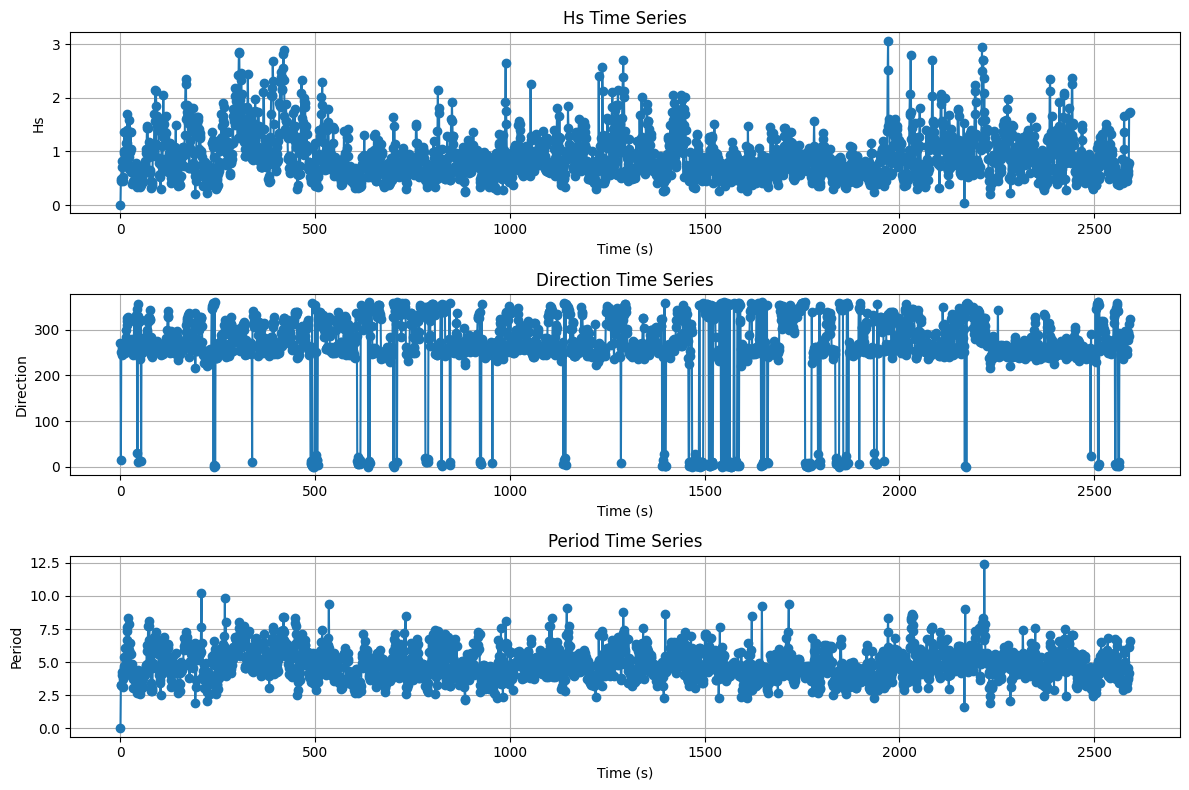

In [10]:

# Create a time array based on the number of time steps
#time_steps = time_combine/86400
#time = np.arange(len(Hs)) * 1  

# calculate numer of time steps in days

count = len(Hs_combine[:,0]) / 8
# round to the lowest integer
count = int(count) * 8


# the data shoul be from 0 to 6480 
Hs = Hs[0:count]
dir = dir[0:count]
per = per[0:count]
time = np.arange(len(Hs)) * 1  

# Create a DataFrame for the time series data   
df = pd.DataFrame({
    'Time (s)': time,
    'Hs': Hs,
    'Direction': dir,
    'Period': per
})
# Plot the time series data
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(df['Time (s)'], df['Hs'], marker='o')
plt.title('Hs Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Hs')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(df['Time (s)'], df['Direction'], marker='o')
plt.title('Direction Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Direction')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(df['Time (s)'], df['Period'], marker='o')
plt.title('Period Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Period')
plt.grid()
plt.tight_layout()
plt.show()


df.to_csv(f'{output_folder}/time_series_data.csv', index=False)


In [24]:
file = f"/p/11207608-coclico/MSc_students/Daniel/Delfland/zm_fromBart_v1/dflowfm/zmd_35m_reloaded_net.nc"
dataset = netCDF4.Dataset(file, 'r')

#print the variables in the file
print(dataset.variables.keys())



dict_keys(['mesh2d', 'projected_coordinate_system', 'mesh2d_node_x', 'mesh2d_node_y', 'mesh2d_node_z', 'mesh2d_edge_x', 'mesh2d_edge_y', 'mesh2d_edge_x_bnd', 'mesh2d_edge_y_bnd', 'mesh2d_edge_nodes', 'mesh2d_face_nodes', 'mesh2d_edge_faces', 'mesh2d_face_x', 'mesh2d_face_y', 'mesh2d_face_x_bnd', 'mesh2d_face_y_bnd'])


[66769.86358037 66835.94542018 66913.41001238 ... 67885.21503443
 68000.10225988 68117.33959304]


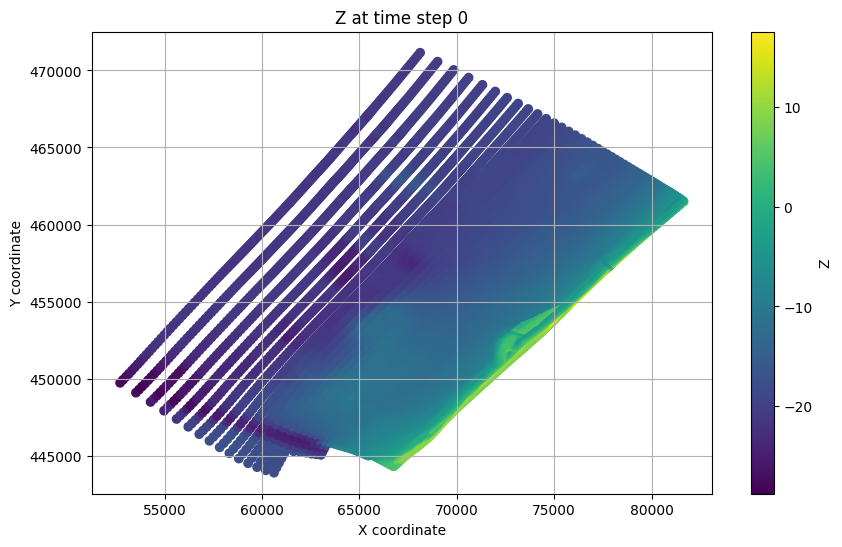

In [25]:
#Extract x,y,z and plot
x = dataset.variables['mesh2d_node_x'][:]
y = dataset.variables['mesh2d_node_y'][:]
z = dataset.variables['mesh2d_node_z'][:]

print(x)
# Create a scatter plot of the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=z, cmap='viridis', marker='o')
plt.colorbar(label='Z')
plt.title('Z at time step 0')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid()
plt.show()
dataset.close()

# generate and export an xyz file
xyz_file = f"/p/11207608-coclico/MSc_students/Daniel/Delfland/este.txt"
with open(xyz_file, 'w') as f:
    for i in range(len(x)):
        f.write(f"{x[i]} {y[i]} {z[i]}\n")



In [9]:
import netCDF4
import numpy as np

# Paths
nc_file = "/p/11207608-coclico/MSc_students/Daniel/Delfland/zm_fromBart_v1/dflowfm/zmd_35m_reloaded_net.nc"
new_xyz_file = "/p/11207608-coclico/MSc_students/Daniel/Delfland/try1.xyz"

# Load the updated Z values from the XYZ file
new_z = []
with open(new_xyz_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 3:
            new_z.append(float(parts[2]))
new_z = np.array(new_z)

# Open NetCDF file in "append" mode to allow editing
with netCDF4.Dataset(nc_file, 'r+') as ds:
    old_z = ds.variables['mesh2d_node_z'][:]
    if len(old_z) != len(new_z):
        raise ValueError("Length mismatch: The XYZ file must have the same number of Z values as the NetCDF file nodes.")
    
    # Overwrite the variable
    ds.variables['mesh2d_node_z'][:] = new_z
    print("✔️ mesh2d_node_z successfully updated in the NetCDF file.")


✔️ mesh2d_node_z successfully updated in the NetCDF file.


In [29]:
import numpy as np
from scipy.spatial import cKDTree

nc_file = "/p/11207608-coclico/MSc_students/Daniel/Delfland/zm_fromBart_v1/dflowfm/zmd_35m_reloaded_net.nc"

# Load the original file (unsorted, correct order)
original_file = f"/p/11207608-coclico/MSc_students/Daniel/Delfland/xyz_v1.txt"  # your original export from netCDF
orig_data = np.loadtxt(original_file)
orig_xy = orig_data[:, :2]

# Load the modified (sorted) QuickIn output
modified_file = f"/p/11207608-coclico/MSc_students/Daniel/Delfland/bathymetries/v2.csv"  # your modified QuickIn output


mod_data = np.loadtxt(modified_file, delimiter=',')
mod_xy = mod_data[:, :2]
mod_z = mod_data[:, 2]

# Build KDTree for nearest neighbor search
tree = cKDTree(mod_xy)

# Find closest points in the modified file for each original point
_, indices = tree.query(orig_xy)

# Get the new Z values in the original order
updated_z = mod_z[indices]

new_z = np.array(updated_z)

# Open NetCDF file in "append" mode to allow editing
with netCDF4.Dataset(nc_file, 'r+') as ds:
    old_z = ds.variables['mesh2d_node_z'][:]
    if len(old_z) != len(new_z):
        raise ValueError("Length mismatch: The XYZ file must have the same number of Z values as the NetCDF file nodes.")
    
    # Overwrite the variable
    ds.variables['mesh2d_node_z'][:] = new_z
    print("✔️ mesh2d_node_z successfully updated in the NetCDF file.")

print(updated_z)

# Combine with original X and Y
updated_data = np.column_stack((orig_xy, updated_z))

# Save corrected file
output_file = "/p/11207608-coclico/MSc_students/Daniel/Delfland/bathymetries/v2.txt"
np.savetxt(output_file, updated_data, fmt="%.10f %.10f %.10f")


✔️ mesh2d_node_z successfully updated in the NetCDF file.
[  4.         4.         4.       ... -20.610242 -20.659468 -20.807122]


In [40]:
input_file = f"/p/11207608-coclico/MSc_students/Daniel/Delfland/bathymetries/v8.csv"
output_file = f"/p/11207608-coclico/MSc_students/Daniel/Delfland/bathymetries/v8.xyz"

with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    for line in infile:
        x, y, z = map(float, line.strip().split(","))
        # Format with reduced decimal places
        outfile.write(f"{x:.16g}\t{y:.16g}\t{z}\n")
